# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import platform

# Functions

In [2]:
# function to get single breath (id must exist...there are some that are missing)
# also once removed u_out=1, lengths are not always 30 (some 28, etc)
def get_breath(df,my_id):
    return df[df.breath_id == my_id] 

In [3]:
def plot_breath(df,my_id):
    id1 = get_breath(df,my_id)
    r = id1.R.iloc[0]
    c = id1.C.iloc[0]
    plt.figure(figsize=(8,5))
    plt.plot(id1.pressure,label='pressure')
    plt.plot(id1.u_in,label='u_in')
    plt.title(f'Pressure and u_in for Breath id={my_id}, R={r}, C={c}')
    plt.legend();

# Load Files

In [4]:
%%time
# Load files
train = pd.read_csv(r'C:\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\train.csv')
test = pd.read_csv(r'C:\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\test.csv')

y = train['pressure']


Wall time: 5.47 s


In [5]:
print(f'Train memory usage: {train.memory_usage().sum()}')
print(f'Test memory usage: {test.memory_usage().sum()}')

Train memory usage: 386304128
Test memory usage: 225344128


# Memory Reduction

In [6]:
# down convert columns to save memory...
# probably do float64's too
# make this a function

# train
train['id'] = train['id'].astype(np.int32)
train['breath_id'] = train['breath_id'].astype(np.int32)
train['R'] = train['R'].astype(np.int8)  #or OHC?
train['C'] = train['C'].astype(np.int8)
train['u_out'] = train['u_out'].astype(np.int8)
train['u_in'] = train['u_in'].astype(np.float32)
train['time_step'] = train['time_step'].astype(np.float32)


#test
test['id'] = test['id'].astype(np.int32)
test['breath_id'] = test['breath_id'].astype(np.int32)
test['R'] = test['R'].astype(np.int8)  #or OHC?
test['C'] = test['C'].astype(np.int8)
test['u_out'] = test['u_out'].astype(np.int8)
test['u_in'] = test['u_in'].astype(np.float32)
test['time_step'] = test['time_step'].astype(np.float32)

for col in test.columns:
    print(test[col].dtype)

int32
int32
int8
int8
float32
float32
int8


In [14]:
print(f'Train memory usage: {train.memory_usage().sum()}')
print(f'Test memory usage: {test.memory_usage().sum()}')


Train memory usage: 162972128
Test memory usage: 76456128


# Split data into inhalitory and exhalitory phase (only scored on inhale)

In [15]:
train_in = train[train.u_out == 0]
test_in = test[test.u_out == 0]
y_in = train_in['pressure']

train_out = train[train.u_out == 1]
test_out = test[test.u_out == 1]

#  Add Features

    1. Apply lag shift (tested shift =1 ) 
        Shift = 2 performs better (2.37 vs. 2.0x)
    2. Add differentials for dt and du_in
    3. Add integral column for d_uin



In [16]:
# apply lag shift in training set
u_in_lag = train_in.u_in.shift(1,fill_value=0)
train_in['u_in_lag'] = u_in_lag
train_in.drop(['u_in'],axis=1,inplace=True)

# and for test set
u_in_lag = test_in.u_in.shift(1,fill_value=0)
test_in['u_in_lag'] = u_in_lag
test_in.drop(['u_in'],axis=1,inplace=True)

In [17]:
train_in.head()

,id,breath_id,R,C,time_step,u_out,pressure,u_in_lag
0,1,1,20,50,0.000000,0,5.837492,0.000000
1,2,1,20,50,0.033652,0,5.907794,0.083334
2,3,1,20,50,0.067514,0,7.876254,18.383041
3,4,1,20,50,0.101542,0,11.742872,22.509277
4,5,1,20,50,0.135756,0,12.234987,22.808823


### Add integral column

In [18]:
# make an index of breaths
train_breath_idx = train_in.breath_id.unique()
test_breath_idx = test_in.breath_id.unique()

### Probably faster way

In [19]:
# much faster area calculation... need to compeletely verify behaviour
# time delta is identical to my dt
# area is idential to u_in_integ, but one step behind (can use to check things.)

train_in['dt'] = train_in['time_step'].diff()
train_in['dt'].fillna(0, inplace=True)  # no na values so not needed
train_in['dt'].mask(train_in['dt'] < 0, train_in.groupby('breath_id')['dt'].mean(), inplace=True)  #makes 

train_in['d_area'] = train_in['dt'] * train_in['u_in_lag']
train_in['du_in_integ'] = train_in.groupby('breath_id')['d_area'].cumsum()#.shift(1,fill_value=0)
    
train_in['du_in'] = train_in['u_in_lag'].diff()  # then look where time delta is 0 and make this 0 also
train_in['du_in'].mask(train_in['dt'] == 0, 0, inplace=True)

# train_in.drop(['dt'],axis=1,inplace=True)
train_in.drop(['d_area'],axis=1,inplace=True)

# same feature additions with test
test_in['dt'] = test_in['time_step'].diff()
test_in['dt'].fillna(0, inplace=True)  # no na values so not needed
test_in['dt'].mask(test_in['dt'] < 0, 0, inplace=True)
test_in['d_area'] = test_in['dt'] * test_in['u_in_lag']
test_in['du_in_integ'] = test_in.groupby('breath_id')['d_area'].cumsum()#.shift(1,fill_value=0)
    
test_in['du_in'] = test_in['u_in_lag'].diff()  # then look where time delta is 0 and make this 0 also
test_in['du_in'].mask(test_in['dt'] == 0, 0, inplace=True)

# test_in.drop(['dt'],axis=1,inplace=True)
test_in.drop(['d_area'],axis=1,inplace=True)

In [20]:
train_in.head(35)

,id,breath_id,R,C,time_step,u_out,pressure,u_in_lag,dt,du_in_integ,du_in
0,1,1,20,50,0.000000,0,5.837492,0.000000,0.000000,0.000000,0.000000
1,2,1,20,50,0.033652,0,5.907794,0.083334,0.033652,0.002804,0.083334
2,3,1,20,50,0.067514,0,7.876254,18.383041,0.033862,0.625293,18.299707
3,4,1,20,50,0.101542,0,11.742872,22.509277,0.034028,1.391235,4.126236
4,5,1,20,50,0.135756,0,12.234987,22.808823,0.034213,2.171600,0.299545
5,6,1,20,50,0.169698,0,12.867706,25.355850,0.033942,3.032233,2.547028
6,7,1,20,50,0.203708,0,14.695562,27.259867,0.034010,3.959346,1.904016
7,8,1,20,50,0.237723,0,15.890699,27.127485,0.034015,4.882080,-0.132381
8,9,1,20,50,0.271776,0,15.539188,26.807732,0.034054,5.794985,-0.319754
9,10,1,20,50,0.305732,0,15.750094,27.864716,0.033955,6.741141,1.056984


In [ ]:
test_in.head()

In [109]:
test_breath_idx

array([     0,      8,     11, ..., 125746, 125747, 125748])

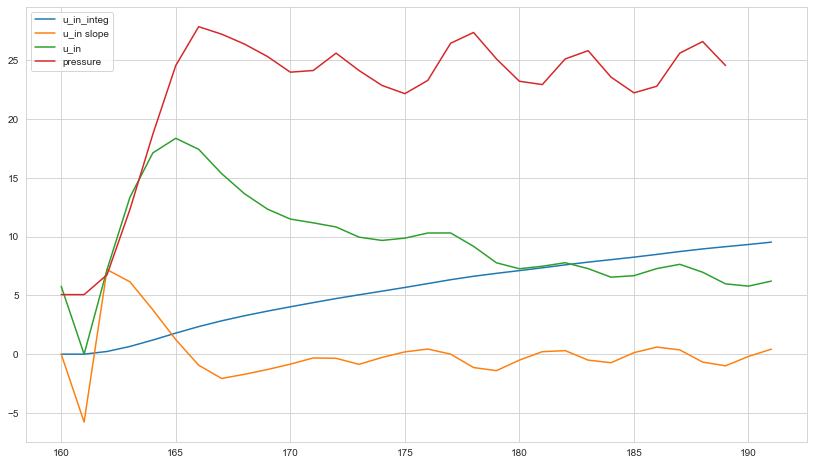

In [118]:
b_num = 3
b1 = get_breath(train_in,b_num)
b2 = get_breath(train,b_num)[0:30]
plt.figure(figsize=(14,8))
plt.plot(b1.du_in_integ,label='u_in_integ')
plt.plot(b1.du_in,label = 'u_in slope')
plt.plot(b1.u_in_lag, label='u_in')
plt.plot(b2.pressure,label='pressure')
plt.legend()

In [111]:
test_in.head()

,id,breath_id,R,C,time_step,u_out,u_in_lag,du_in_integ,du_in
0,1,0,5,20,0.000000,0,0.000000,0.000000,0.000000
1,2,0,5,20,0.031904,0,0.000000,0.000000,0.000000
2,3,0,5,20,0.063827,0,7.515046,0.239907,7.515046
3,4,0,5,20,0.095751,0,14.651675,0.707644,7.136630
4,5,0,5,20,0.127644,0,21.230610,1.384742,6.578935


In [112]:
#train_in.to_pickle('train_in_lag_w_feat')
#test_in.to_pickle('test_in_lag_w_feat')

In [113]:
# dt seems one index point off
#plt.plot(train_in.du_in_integ[0:30])
#plt.plot(train_in.dt[0:30])


# Model

In [114]:
from sklearn.metrics import mean_absolute_error  #confusion_matrix, classification_report

In [115]:
# Split data - after all analysis is done
from sklearn.model_selection import train_test_split

train_in.drop(columns = ['pressure','id'], inplace = True)
#test = test.drop(columns = 'id', inplace = True)

X_train, X_valid, y_train, y_valid = train_test_split(train_in, y_in, train_size=0.8, test_size=0.2,
                                                      random_state=12)
X_test_in = test_in.drop(columns=['id'],inplace=False)

In [116]:
# Logistic Regression - not working...yet.
X_test_in

,breath_id,R,C,time_step,u_out,u_in_lag,du_in_integ,du_in
0,0,5,20,0.000000,0,0.000000,0.000000,0.000000
1,0,5,20,0.031904,0,0.000000,0.000000,0.000000
2,0,5,20,0.063827,0,7.515046,0.239907,7.515046
3,0,5,20,0.095751,0,14.651675,0.707644,7.136630
4,0,5,20,0.127644,0,21.230610,1.384742,6.578935
...,...,...,...,...,...,...,...,...
4023945,125748,20,10,0.842145,0,0.000000,2.319345,0.000000
4023946,125748,20,10,0.875648,0,0.000000,2.319345,0.000000
4023947,125748,20,10,0.909185,0,0.000000,2.319345,0.000000
4023948,125748,20,10,0.943148,0,0.121375,2.323468,0.121375


In [117]:
%%time
from catboost import CatBoostRegressor
# loop for manual type cv
#preds = []
for i in np.arange(1,2):
#     X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, test_size=0.2,
#                                                       random_state=i)
    model_cat = CatBoostRegressor(loss_function="MAE",
                               eval_metric="MAE",
                               task_type="GPU",
                               learning_rate=.6,
                               iterations=400,
                               l2_leaf_reg=50,
                               random_seed=12,
                               od_type="Iter",
                               depth=5,
                               #early_stopping_rounds=6500,
                               border_count=64,
                               verbose=False
                              )
    model_cat.fit(X_train,y_train)
    pred_cat = model_cat.predict(X_valid)
    score_cat = mean_absolute_error(y_valid,pred_cat)
    #print(f'iters={i}, lr={j}, CatBoost MAE Score: {score_cat}')
    print(f'CatBoost MAE Score: {score_cat}')
    #preds.append(model_cat.predict_proba(X_test)[:,1])
    # 400, .6 = 3.976 
    # with deriv, integral
    # 400, .6 = 1.42
    # 4000,.6 = 1.21 (1.18 lb)
    # 8000,.6 = 1.12 (1.14 lb) maybe starting to overfit
    # shift = 1 (still need to review lining up)
    # 400, .6 = 1.22
    # 4000: 1.1277 
    # try shift = 2, = 1.23 with 4000,.6 (worse)

    # new params with faster integ method...worse..
    # shift = 0: 1.54
    # shift = 1: 1.42
    # shift =2: 1.53

CatBoost MAE Score: 1.4705702556440459
Wall time: 43.4 s


In [ ]:
%%time
#random forest
# from sklearn.ensemble import RandomForestRegressor
# model_rf = RandomForestRegressor()
# model_rf.fit(X_train, y_train)
# pred_rf = model_rf.predict(X_valid)
# rf_mae = mean_absolute_error(pred_rf,y_valid)
# print(f'Random Forest MAE Score: {rf_mae}')

# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12), mae=3.12775, lb score = 6.431(?)
# Why is random forest worse?  
# 10/17/21: Still worse after using only inhales
# defaults: runs out of memory!!!???
# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12) = 5.867
# reduced dtype sizes on ints: 
# 3.627 default, lb = 3.710
# changed criterion to mae...doesn't work...removed

# with dt and du_in, shift=1, 2.364 vs. lb of 2.37.  Beats catboost (400,.6)
# with dt and du_in, shift=2, Random Forest MAE Score: 2.058162936194095
# with dt and du_in, shift=3, Random Forest MAE Score: 2.03014981349922
# interesting shift 3 is a little better.

# deriv and integral, shift=1, .7934!!!
# but leaderboard was .8897
# try shift = 2, = .934 (a little lower)

# Final Model Submission

In [ ]:
pred_final = model_rf.predict(X_test_in)
# add indexs to recombine with out preds
pred_final_s = pd.Series(pred_final,index=list(test_in.id))
pred_final_s.head()

In [ ]:
# create outpreds = just ones
out_preds = np.ones(len(test_out))
i = list(test_out.id)
out_preds_s = pd.Series(out_preds,index = i)
out_preds_s

In [ ]:
both = pred_final_s.append(out_preds_s).sort_index()
both.values

In [ ]:
output = pd.DataFrame({'id': test.id, 'pressure': both.values})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

## Post Analyze prediction vs. actuals and look for trends

In [ ]:
%%time
### predictions vs. validation data
pred_rf_all = model_rf.predict(train_in)

In [ ]:
y_in.values

In [ ]:
#Create a dataframe with breath_id's to make plotting easier
post_analysis = pd.DataFrame({'breath_id': train_in.breath_id, 'prediction': pred_rf_all, 'acutal': y_in.values})
post_analysis['residual'] = pred_rf_all - y_in.values
post_analysis['R'] = train_in.R
post_analysis['C'] = train_in.C
post_analysis['u_in_lag'] = train_in.u_in_lag


In [ ]:
post_analysis.head()

In [ ]:
# make this a function
breath_idx = train_in.breath_id.unique()
fig, ax = plt.subplots(6, 4, figsize=(25,30))
ax = ax.flatten()
for i in range(24):
    b_id = get_breath(post_analysis,breath_idx[i])
    r = b_id.R.iloc[0]
    c = b_id.C.iloc[0]
    ax[i].plot(b_id.prediction,label='prediction')
    ax[i].plot(b_id.acutal,label='actual')
    ax[i].set_title(f'RR Prediction and Actual: Shift=1, Breath id={i}, R={r}, C={c}')
    ax[i].legend();
    
plt.savefig('RndFrst_pred_actual_shift=1.png')
